Required libraries for Support Vector Machines (SVM)

- pandas
- scikit-learn
- matplotlib
- seaborn

> Ensure required libraries are installed before running the notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score, balanced_accuracy_score, classification_report
from sklearn.inspection import permutation_importance


Load the dataset to be used

In [2]:
# Load dataset
train_df = pd.read_csv('train_data_with_traffic_class.csv')
test_df = pd.read_csv('test_data_with_traffic_class.csv')

PLACEHOLDER

In [3]:
# Define features (X) and target (y) for training dataset
X_train_features = train_df.drop(columns=["Total_Traffic", "Departures", "Arrivals", "Traffic_Class", "Month"])
# Encode categorical variables with One-hot encoding
X_train_features = pd.get_dummies(X_train_features, columns=["Country"], drop_first=True)
y_train_labels = train_df["Traffic_Class"]

# Define features (X) and target (y) for test dataset
X_test_features = test_df.drop(columns=["Total_Traffic", "Departures", "Arrivals", "Traffic_Class", "Month"])
# Encode categorical variables with One-hot encoding
X_test_features = pd.get_dummies(X_test_features, columns=["Country"], drop_first=True)
y_test_labels = test_df["Traffic_Class"]

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_features, y_train_labels, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test_features)

PLACEHOLDER

In [4]:
svm_classifier = SVC(kernel='linear', random_state=42)

svm_classifier.fit(X_train_scaled, y_train)

# Make predictions on the scaled test data
y_val_pred = svm_classifier.predict(X_val_scaled)

# Evaluate model performance on the validation set
accuracy = accuracy_score(y_val, y_val_pred)
balanced_acc = balanced_accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation Balanced Accuracy: {balanced_acc:.4f}")

unique_classes = np.unique(y_val)
target_names = [str(cls) for cls in unique_classes]  # Convert to string if necessary

# Display classification report with precision, recall, f1-score, and support
print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=target_names))

# Now, validate the model on the test set
y_test_pred = svm_classifier.predict(X_test_scaled)

# Evaluate model performance on the test set
test_accuracy = accuracy_score(y_test_labels, y_test_pred)
test_balanced_acc = balanced_accuracy_score(y_test_labels, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Balanced Accuracy: {test_balanced_acc:.4f}")

# Display classification report for the test set
print("\nTest Classification Report:")
print(classification_report(y_test_labels, y_test_pred, target_names=target_names))

Validation Accuracy: 0.8946
Validation Balanced Accuracy: 0.8737

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.78      0.77       330
           1       0.94      0.93      0.93      1092
           2       0.97      0.91      0.94        68

    accuracy                           0.89      1490
   macro avg       0.89      0.87      0.88      1490
weighted avg       0.90      0.89      0.90      1490

Test Accuracy: 0.8797
Test Balanced Accuracy: 0.6540

Test Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.96      0.86       177
           1       0.97      0.98      0.97       229
           2       1.00      0.02      0.05        43

    accuracy                           0.88       449
   macro avg       0.92      0.65      0.63       449
weighted avg       0.90      0.88      0.84       449



PLACEHOLDER

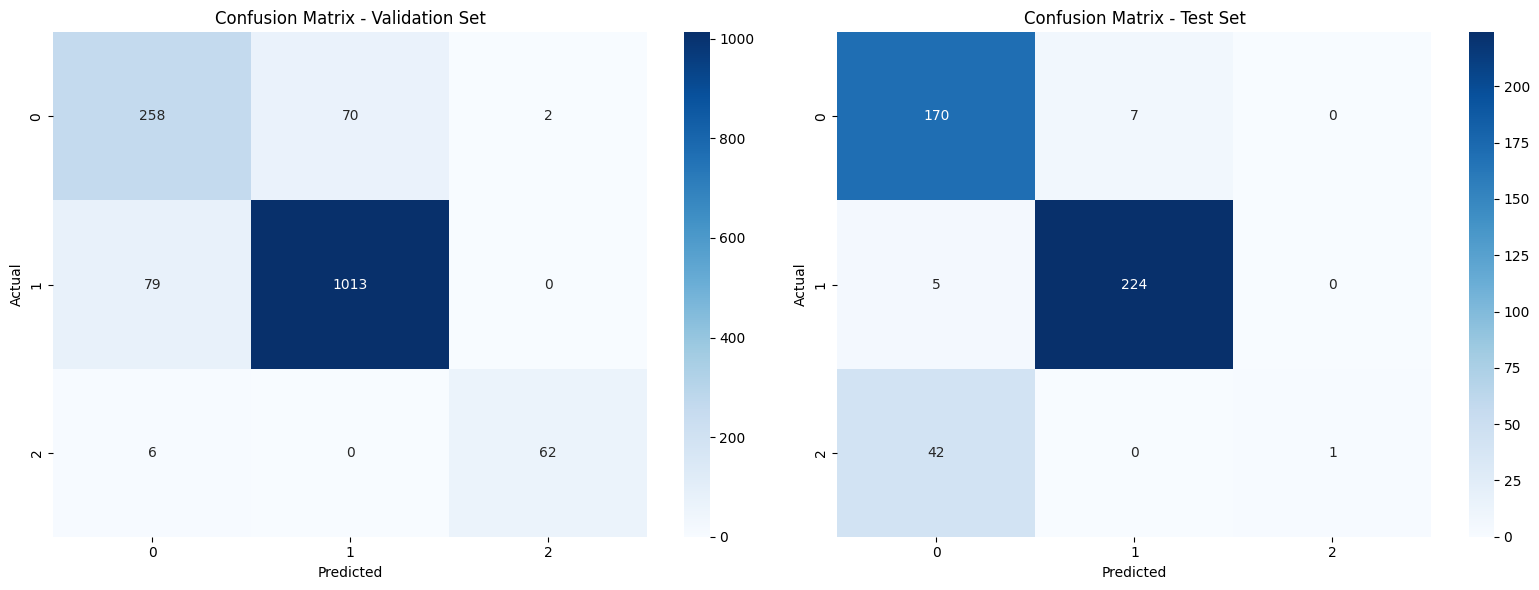

In [5]:
# Create confusion matrices
cm_val = confusion_matrix(y_val, y_val_pred)
cm_test = confusion_matrix(y_test_labels, y_test_pred)

# Set up the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# Plot validation confusion matrix
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names, ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix - Validation Set')

# Plot test confusion matrix
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names, ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Confusion Matrix - Test Set')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

PLACEHOLDER

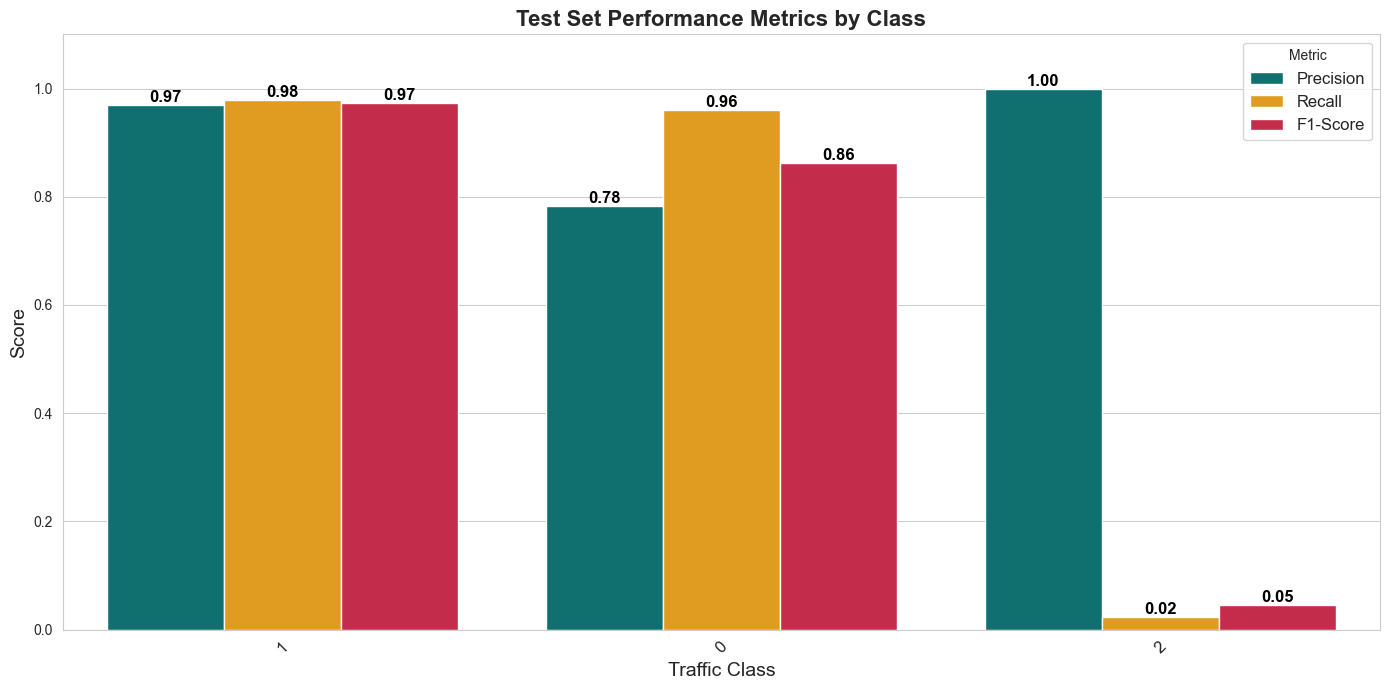

In [6]:
# Calculate metrics for each class
precision, recall, f1, _ = precision_recall_fscore_support(y_test_labels, y_test_pred)

# Create a DataFrame
metrics_df = pd.DataFrame({
    'Class': target_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
})
 
# Sort by F1-Score (descending) for better visualization
metrics_df = metrics_df.sort_values(by="F1-Score", ascending=False)

# Melt for easier plotting
metrics_melt = pd.melt(metrics_df, id_vars=['Class'], 
                      value_vars=['Precision', 'Recall', 'F1-Score'],
                      var_name='Metric', value_name='Score')

# Plot
plt.figure(figsize=(14, 7))
sns.set_style("whitegrid")  # Add a clean grid style
palette = {"Precision": "teal", "Recall": "orange", "F1-Score": "crimson"}  # Custom colors

ax = sns.barplot(data=metrics_melt, x='Class', y='Score', hue='Metric', palette=palette)

# Add value labels to each bar
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Only annotate bars with height > 0
        ax.annotate(f'{height:.2f}', 
                    (p.get_x() + p.get_width() / 2, height), 
                    ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

# Titles and labels
plt.title('Test Set Performance Metrics by Class', fontsize=16, fontweight='bold')
plt.xlabel('Traffic Class', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.ylim(0, 1.1)  # Slightly above 1 for better spacing
plt.xticks(rotation=45, fontsize=12)
plt.legend(title='Metric', fontsize=12)
plt.tight_layout()

# Show plot
plt.show()

PLACEHOLDER

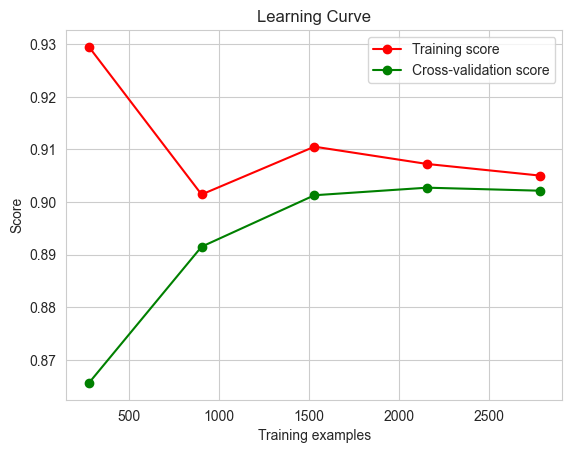

In [7]:
train_sizes, train_scores, val_scores = learning_curve(svm_classifier, X_train_scaled, y_train, cv=5)

train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.show()

PLACEHOLDER

In [8]:
# Define the parameter grid
tuned_parameters = [
    {'kernel': ['rbf'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5], 'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
    {'kernel': ['sigmoid'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5], 'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
    {'kernel': ['linear'], 'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]}
]

PLACEHOLDER

In [9]:
# Initialize the SVM classifier with class weights
svm_classifier = SVC(random_state=42, class_weight='balanced')

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=svm_classifier,
    param_grid=tuned_parameters,
    scoring='balanced_accuracy',  # Use a robust metric
    cv=10,
    n_jobs=-1,
    verbose=2
)

# Perform grid search on the scaled training data
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Balanced Accuracy: {best_score:.4f}")

Fitting 10 folds for each of 72 candidates, totalling 720 fits
Best Parameters: {'C': 50, 'gamma': 0.001, 'kernel': 'rbf'}
Best Cross-Validation Balanced Accuracy: 0.9291


PLACEHOLDER

In [10]:
# Evaluate the best model on the validation set
best_svm = grid_search.best_estimator_
y_val_pred = best_svm.predict(X_val_scaled)

# Evaluate model performance on the validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
balanced_acc = balanced_accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Balanced Accuracy: {balanced_acc:.4f}")

unique_classes = np.unique(y_val)
target_names = [str(cls) for cls in unique_classes]  # Convert to string if necessary

# Display classification report with precision, recall, f1-score, and support
print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=target_names))

# Now, validate the model on the test set
y_test_pred = best_svm.predict(X_test_scaled)

# Evaluate model performance on the test set
test_accuracy = accuracy_score(y_test_labels, y_test_pred)
test_balanced_acc = balanced_accuracy_score(y_test_labels, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Balanced Accuracy: {test_balanced_acc:.4f}")

# Display classification report for the test set
print("\nTest Classification Report:")
print(classification_report(y_test_labels, y_test_pred, target_names=target_names))

Validation Accuracy: 0.8785
Validation Balanced Accuracy: 0.9254

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.94      0.79       330
           1       0.99      0.85      0.92      1092
           2       0.66      0.99      0.79        68

    accuracy                           0.88      1490
   macro avg       0.78      0.93      0.83      1490
weighted avg       0.91      0.88      0.88      1490

Test Accuracy: 0.9688
Test Balanced Accuracy: 0.9762

Test Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       177
           1       1.00      0.97      0.98       229
           2       0.86      1.00      0.92        43

    accuracy                           0.97       449
   macro avg       0.94      0.98      0.96       449
weighted avg       0.97      0.97      0.97       449



PLACEHOLDER

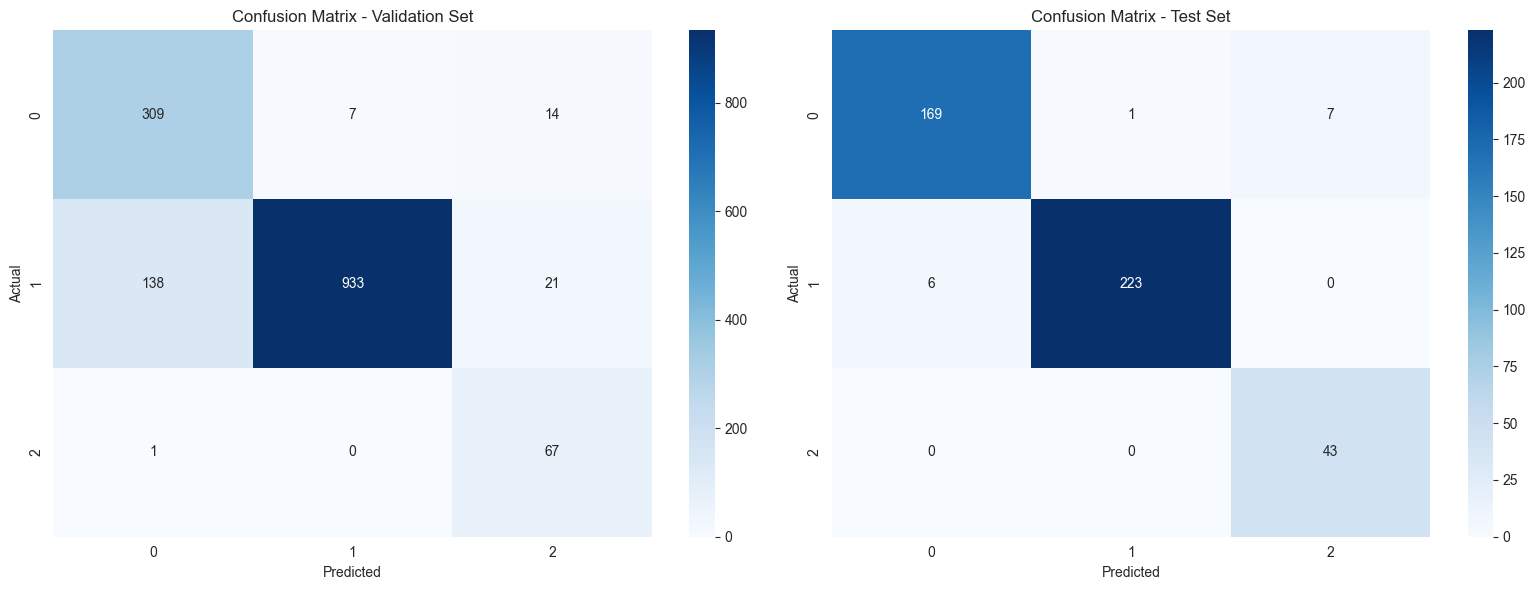

In [11]:
# Create confusion matrices
cm_val = confusion_matrix(y_val, y_val_pred)
cm_test = confusion_matrix(y_test_labels, y_test_pred)

# Plot side-by-side confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names, ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix - Validation Set')

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names, ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Confusion Matrix - Test Set')

plt.tight_layout()
plt.show()

PLACEHOLDER

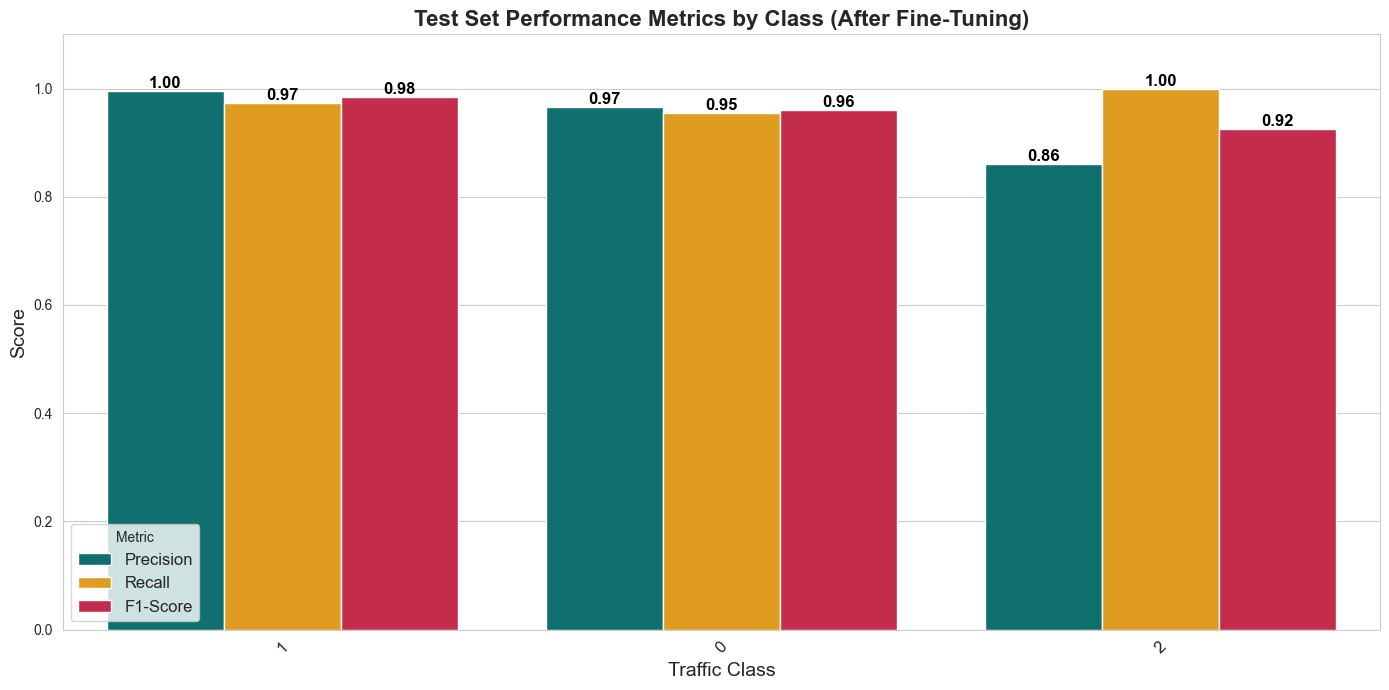

In [12]:
# Calculate metrics for each class
precision, recall, f1, _ = precision_recall_fscore_support(y_test_labels, y_test_pred)

# Create a DataFrame
metrics_df = pd.DataFrame({
    'Class': target_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
})

# Sort by F1-Score (descending) for better visualization
metrics_df = metrics_df.sort_values(by="F1-Score", ascending=False)

# Melt for easier plotting
metrics_melt = pd.melt(metrics_df, id_vars=['Class'], 
                      value_vars=['Precision', 'Recall', 'F1-Score'],
                      var_name='Metric', value_name='Score')

# Plot
plt.figure(figsize=(14, 7))
sns.set_style("whitegrid")  # Add a clean grid style
palette = {"Precision": "teal", "Recall": "orange", "F1-Score": "crimson"}  # Custom colors

ax = sns.barplot(data=metrics_melt, x='Class', y='Score', hue='Metric', palette=palette)

# Add value labels to each bar
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Only annotate bars with height > 0
        ax.annotate(f'{height:.2f}', 
                    (p.get_x() + p.get_width() / 2, height), 
                    ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

# Titles and labels
plt.title('Test Set Performance Metrics by Class (After Fine-Tuning)', fontsize=16, fontweight='bold')
plt.xlabel('Traffic Class', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.ylim(0, 1.1)  # Slightly above 1 for better spacing
plt.xticks(rotation=45, fontsize=12)
plt.legend(title='Metric', fontsize=12)
plt.tight_layout()

# Show plot
plt.show()

PLACEHOLDER

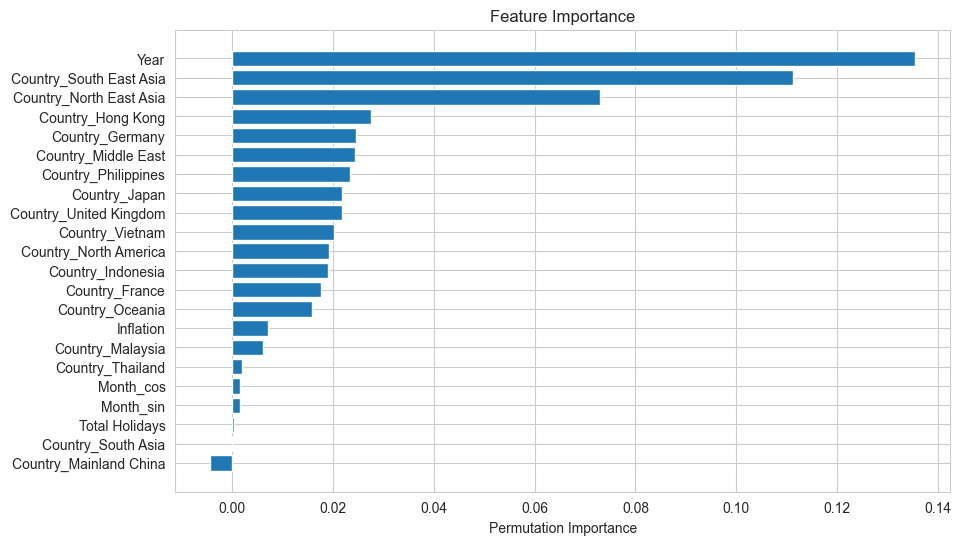

In [13]:
# Calculate permutation importance
result = permutation_importance(best_svm, X_val_scaled, y_val, n_repeats=10, random_state=42)

# Plot feature importance
sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(10, 6))
plt.barh(range(X_train.shape[1]), result.importances_mean[sorted_idx], align='center')
plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Feature Importance')
plt.show()

PLACEHOLDER

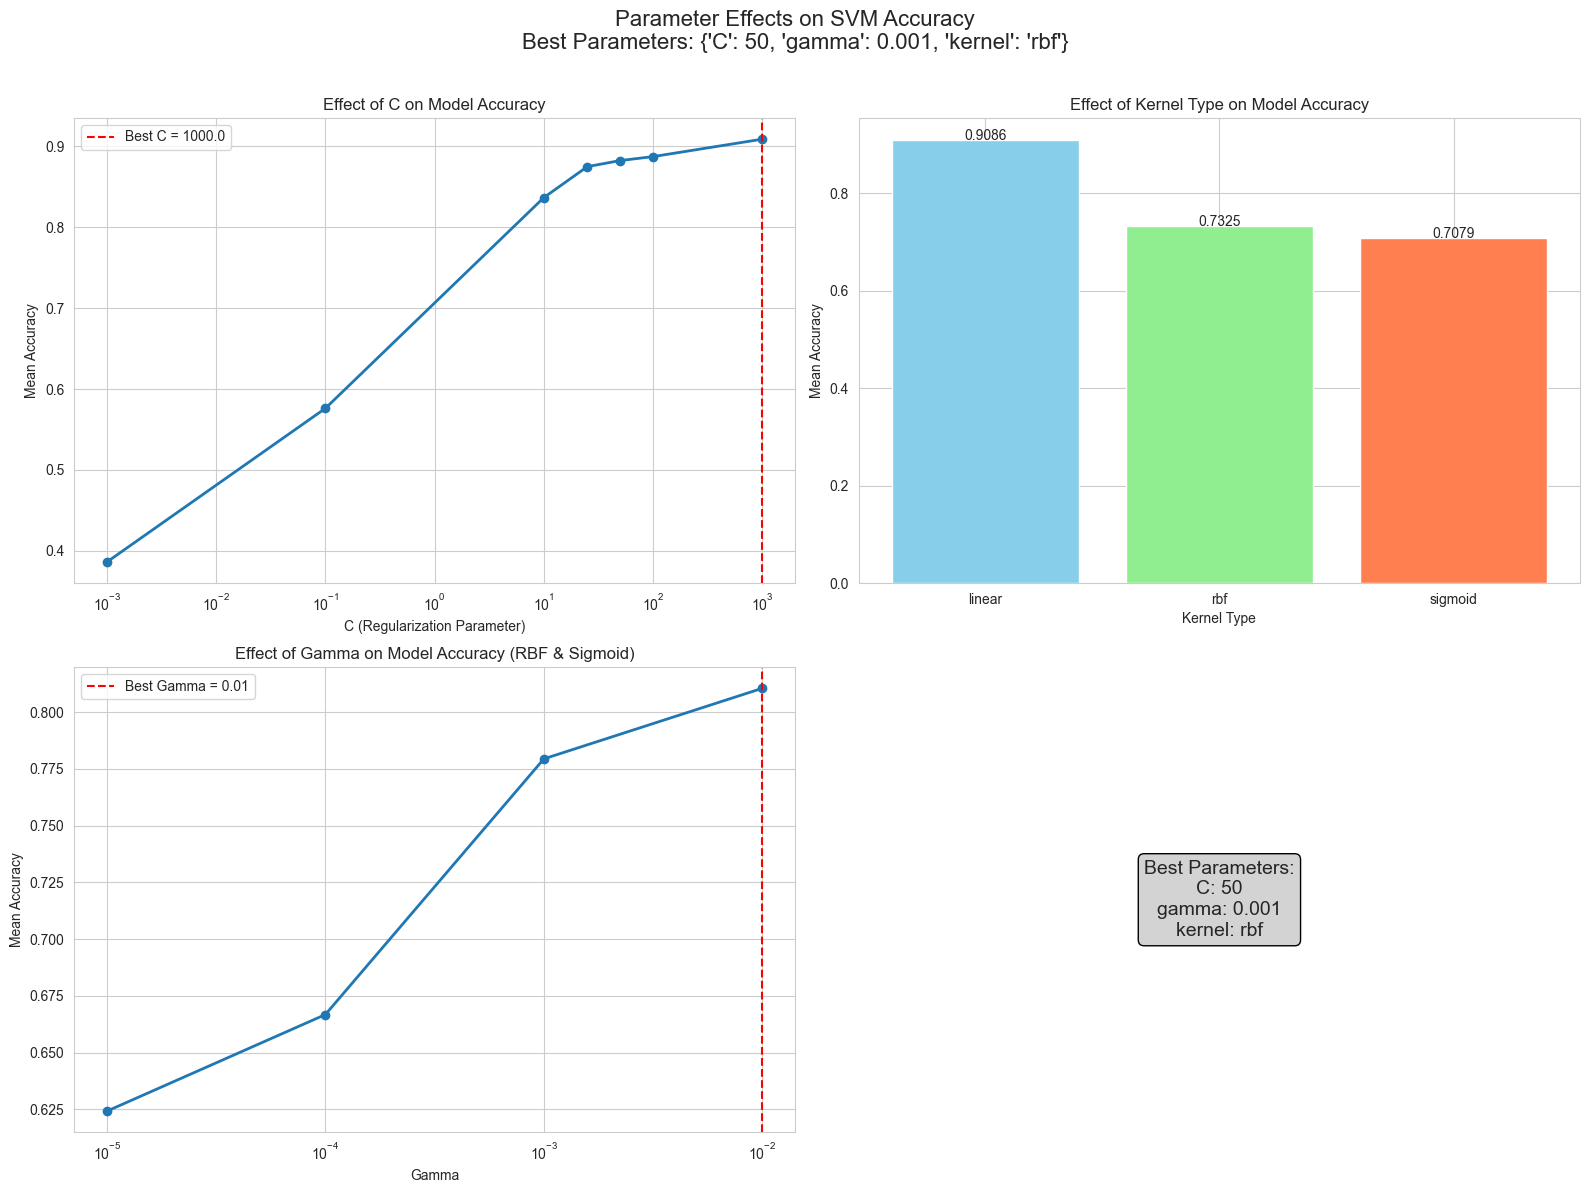

In [14]:
# Extract results from GridSearchCV
results = pd.DataFrame(grid_search.cv_results_)

# Set up the figure
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Effect of C on Accuracy
c_df = results.groupby('param_C')['mean_test_score'].mean().reset_index()
axs[0, 0].plot(c_df['param_C'], c_df['mean_test_score'], 'o-', linewidth=2)
axs[0, 0].set_xscale('log')  # Log scale for better visualization
axs[0, 0].set_xlabel('C (Regularization Parameter)')
axs[0, 0].set_ylabel('Mean Accuracy')
axs[0, 0].set_title('Effect of C on Model Accuracy')
axs[0, 0].grid(True)
best_c = c_df.loc[c_df['mean_test_score'].idxmax(), 'param_C']
axs[0, 0].axvline(x=best_c, color='r', linestyle='--', label=f'Best C = {best_c}')
axs[0, 0].legend()

# Effect of Kernel Type on Accuracy
kernel_df = results.groupby('param_kernel')['mean_test_score'].mean().reset_index()
axs[0, 1].bar(kernel_df['param_kernel'], kernel_df['mean_test_score'], color=['skyblue', 'lightgreen', 'coral'])
axs[0, 1].set_xlabel('Kernel Type')
axs[0, 1].set_ylabel('Mean Accuracy')
axs[0, 1].set_title('Effect of Kernel Type on Model Accuracy')
for i, v in enumerate(kernel_df['mean_test_score']):
    axs[0, 1].text(i, v + 0.001, f"{v:.4f}", ha='center')
axs[0, 1].grid(True, axis='y')

# Effect of Gamma on Accuracy (Only for RBF & Sigmoid Kernels)
if 'param_gamma' in results.columns:
    gamma_df = results.groupby('param_gamma')['mean_test_score'].mean().reset_index()
    axs[1, 0].plot(gamma_df['param_gamma'], gamma_df['mean_test_score'], 'o-', linewidth=2)
    axs[1, 0].set_xscale('log')  # Log scale for better visualization
    axs[1, 0].set_xlabel('Gamma')
    axs[1, 0].set_ylabel('Mean Accuracy')
    axs[1, 0].set_title('Effect of Gamma on Model Accuracy (RBF & Sigmoid)')
    axs[1, 0].grid(True)
    best_gamma = gamma_df.loc[gamma_df['mean_test_score'].idxmax(), 'param_gamma']
    axs[1, 0].axvline(x=best_gamma, color='r', linestyle='--', label=f'Best Gamma = {best_gamma}')
    axs[1, 0].legend()

# Best Parameter Combinations
axs[1, 1].axis('off')  # Hide the plot space
best_params_text = "\n".join([f"{key}: {value}" for key, value in grid_search.best_params_.items()])
axs[1, 1].text(0.5, 0.5, f"Best Parameters:\n{best_params_text}", 
               fontsize=14, ha='center', va='center', 
               bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='lightgrey'))

# Add a title for the entire figure
fig.suptitle(f'Parameter Effects on SVM Accuracy\nBest Parameters: {grid_search.best_params_}', 
             fontsize=16, y=0.99)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


In [15]:
from sklearn.model_selection import cross_val_score

# Perform k-fold cross-validation with the best model
cv_scores = cross_val_score(best_svm, X_train, y_train, cv=10, scoring='accuracy') #10-fold

print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {cv_scores.mean():.4f}")

Cross-Validation Scores: [0.89655172 0.89655172 0.87356322 0.87356322 0.88218391 0.870317
 0.89337176 0.85590778 0.84149856 0.87608069]
Mean Cross-Validation Accuracy: 0.8760
